# Testing of smart_transpile

In this Notebook, the smart_transpile function will be tested on effectiveness on a small number of random quantum circuits. 

## Step 1: Create Quantum Circuits

For qubit counts {4, 8, 12, 16, 20, 24}, build each 12 random quantum circuits, wich are diveded eaqualy into three categories of different depth levels {20, 50, 80}. So that leaves us with 72 quantum circuits in total.

In [1]:
from qiskit.circuit.random import random_circuit

qubit_counts = [2,4, 6, 8, 10, 12, 14, 16]
depths       = [10,20]
per_depth    = 3

q_circuits = []

for qubits in qubit_counts:
    for depth in depths:
        for i in range(per_depth):
            qc = random_circuit(qubits, depth, measure=False, seed=(i+depth + qubits))
            q_circuits.append((qubits, depth, qc))

print(len(q_circuits))


48


## Step 2: Transpilation

First we'll chose three different IBM Backends we want to test the smart_transpile on. This will be ibm_marrakesh (156 Qubits), ibm_sherbrooke and ibm_brisbane (127 Qubits each) or to be more precice thei respective fake backend (Simulations). Then for each backend we'll create two arrays, one with the smmart_transpiled circuits and one with usual pass_manager provided by qiskit.

In [2]:
from qiskit_ibm_runtime.fake_provider import FakeMarrakesh, FakeSherbrooke, FakeBrisbane
backends = {
    "marrakesh": FakeMarrakesh(),     # 156 qubits
    "sherbrooke": FakeSherbrooke(), # 127 qubits
    "brisbane": FakeBrisbane()      # 127 qubits
}


Before we transpile we mirror all the Circuits - this will give us a way to measure error effectiveness of the smart_transpile function.

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister

def add_measurements_only_on_active_qubits(qc):
    active_qubits = set()
    for instr, qargs, _ in qc.data:
        for q in qargs:
            active_qubits.add(qc.qubits.index(q))
    active_qubits = sorted(active_qubits)

    creg = ClassicalRegister(len(active_qubits))
    qc.add_register(creg)

    for i, qubit_idx in enumerate(active_qubits):
        qc.measure(qc.qubits[qubit_idx], creg[i])

    return qc

In [4]:
def mirror_circuit(qc):
    num_qubits = qc.num_qubits

    qc_no_meas = QuantumCircuit(num_qubits)
    for instruction in qc.data:
        if instruction.operation.name != "measure":
            qc_no_meas.append(instruction.operation, instruction.qubits, instruction.clbits)

    qc_inverse = qc_no_meas.inverse()

    qc_mirrored = qc_no_meas.copy()
    qc_mirrored.barrier()
    qc_mirrored.compose(qc_inverse, inplace=True)

    qc_mirrored = add_measurements_only_on_active_qubits(qc_mirrored)

    return qc_mirrored

In [5]:
# Mirror logical circuits BEFORE transpiling
mirrored_circuits = []
for (n, d, qc) in q_circuits:
    qc_mirrored = mirror_circuit(qc)
    mirrored_circuits.append((n, d, qc_mirrored))


C:\Users\Ruben\AppData\Local\Temp\ipykernel_5812\277245032.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in qc.data:


Now we can transpile - this can take a while.


In [ ]:
from qiskit import transpile
from smart_pass_manager import smart_transpile

default_circuits = {}
smart_circuits   = {}
count = 0
for name, fake_backend in backends.items():
    defaults = []
    smarts   = []
    for (n, d, qc_mirrored) in mirrored_circuits:
        # Default transpile
        qc_def = transpile(qc_mirrored, backend=fake_backend, optimization_level=3)
        defaults.append((n, d, qc_def))

        # Smart transpile
        qc_smart = smart_transpile(qc_mirrored, backend=fake_backend, optimization_level=3, seed=0)
        smarts.append((n, d, qc_smart))

        count += 2
        print("Percentage: ", count / (2 * len(mirrored_circuits) * len(backends)))

    default_circuits[name] = defaults
    smart_circuits[name]   = smarts

    # This took me 47min to run

Percentage:  0.006944444444444444
Percentage:  0.013888888888888888
Percentage:  0.020833333333333332
Percentage:  0.027777777777777776
Percentage:  0.034722222222222224
Percentage:  0.041666666666666664
Percentage:  0.04861111111111111
Percentage:  0.05555555555555555
Percentage:  0.0625
Percentage:  0.06944444444444445
Percentage:  0.0763888888888889
Percentage:  0.08333333333333333
Percentage:  0.09027777777777778
Percentage:  0.09722222222222222
Percentage:  0.10416666666666667
Percentage:  0.1111111111111111
Percentage:  0.11805555555555555
Percentage:  0.125
Percentage:  0.13194444444444445
Percentage:  0.1388888888888889
Percentage:  0.14583333333333334
Percentage:  0.1527777777777778
Percentage:  0.1597222222222222
Percentage:  0.16666666666666666
Percentage:  0.1736111111111111
Percentage:  0.18055555555555555
Percentage:  0.1875
Percentage:  0.19444444444444445
Percentage:  0.2013888888888889
Percentage:  0.20833333333333334
Percentage:  0.2152777777777778
Percentage:  0.2222

## Step 3: Run on simulated backend

We prepare the simulators with the right noise model.

In [ ]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel


simulators = {}

for name, fake_backend in backends.items():
    
    noise_model = NoiseModel.from_backend(fake_backend)
    
    simulator = AerSimulator(noise_model=noise_model)
    
    simulators[name] = simulator


To reduce computation time, while still maintaining meaningful results we choose the number of shots depending on number of qubits in circuit.

In [ ]:
def determine_shots(num_qubits):
    if num_qubits <= 8:
        return 5000
    elif num_qubits <= 16:
        return 2000
    else:
        return 1000

Reduce Circuits to active Qubits only

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def reduce_to_active_qubits(qc):
    """Rebuild a QuantumCircuit to only include active qubits and classical bits."""
    active_qubits = set()
    for instr, qargs, _ in qc.data:
        for q in qargs:
            active_qubits.add(qc.qubits.index(q))
    active_qubits = sorted(active_qubits)
    
    old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(active_qubits)}
    qr = QuantumRegister(len(active_qubits), "q")
    cr = ClassicalRegister(len(active_qubits), "c")
    new_qc = QuantumCircuit(qr, cr)
    
    for instr, qargs, cargs in qc.data:
        new_qargs = [qr[old_to_new[qc.qubits.index(q)]] for q in qargs]
        if instr.name == "measure":
            new_cargs = []
            for q in qargs:
                qubit_idx = qc.qubits.index(q)
                clbit_idx = old_to_new[qubit_idx]
                new_cargs.append(cr[clbit_idx])
        else:
            new_cargs = []
        new_qc.append(instr.copy(), new_qargs, new_cargs)
    
    new_qc.global_phase = qc.global_phase
    new_qc.name = qc.name

    return new_qc

Define the results and run all the simulations


In [ ]:
results_default = {}
results_smart = {}
counter = 0

for backend_name in backends.keys():
    simulator = simulators[backend_name]
    
    circuits_def = default_circuits[backend_name]
    circuits_smart = smart_circuits[backend_name]

    success_rates_def = []
    success_rates_smart = []

    # Run default circuits
    for n, d, qc_mirrored in circuits_def:
        shots = determine_shots(n)
    	
        qc_mirrored_reduced = reduce_to_active_qubits(qc_mirrored)

        transpiled = transpile(qc_mirrored_reduced, simulator, optimization_level=0)
        job = simulator.run(transpiled, shots=shots)
        result = job.result()

        counts = result.get_counts()
        zero_string = '0' * n
        success = counts.get(zero_string, 0) / shots
        success_rates_def.append(success)

        counter += 1
        print("Percentage: ", counter / (2 * len(mirrored_circuits) * len(backends)))

    # Run smart circuits
    for n, d, qc_mirrored in circuits_smart:
        shots = determine_shots(n)

        qc_mirrored_reduced = reduce_to_active_qubits(qc_mirrored)

        transpiled = transpile(qc_mirrored_reduced, simulator, optimization_level=0)
        job = simulator.run(transpiled, shots=shots)
        result = job.result()

        counts = result.get_counts()
        zero_string = '0' * n
        success = counts.get(zero_string, 0) / shots
        success_rates_smart.append(success)

        counter += 1
        print("Percentage: ", counter / (2 * len(mirrored_circuits) * len(backends)))

    # Store results
    results_default[backend_name] = success_rates_def
    results_smart[backend_name] = success_rates_smart

C:\Users\Ruben\AppData\Local\Temp\ipykernel_9792\2923525979.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in qc.data:
C:\Users\Ruben\AppData\Local\Temp\ipykernel_9792\2923525979.py:16: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


Percentage:  0.003472222222222222
Percentage:  0.006944444444444444
Percentage:  0.010416666666666666
Percentage:  0.013888888888888888
Percentage:  0.017361111111111112
Percentage:  0.020833333333333332
Percentage:  0.024305555555555556
Percentage:  0.027777777777777776
Percentage:  0.03125
Percentage:  0.034722222222222224
Percentage:  0.03819444444444445
Percentage:  0.041666666666666664
Percentage:  0.04513888888888889
Percentage:  0.04861111111111111
Percentage:  0.052083333333333336
Percentage:  0.05555555555555555
Percentage:  0.059027777777777776
Percentage:  0.0625
Percentage:  0.06597222222222222
Percentage:  0.06944444444444445
Percentage:  0.07291666666666667
Percentage:  0.0763888888888889
Percentage:  0.0798611111111111
Percentage:  0.08333333333333333
Percentage:  0.08680555555555555
Percentage:  0.09027777777777778
Percentage:  0.09375
Percentage:  0.09722222222222222
Percentage:  0.10069444444444445
Percentage:  0.10416666666666667
Percentage:  0.1076388888888889
Perce

## Step 4: Post-Process

In This final part we'll post-process the results. Meaning drawing diagramms. First we prepare and sort the data neatly using panda.

In [ ]:
# DataFrame with Backend, Method, Qubits, Depth, SuccessRate
import pandas as pd

data = []

for backend_name in backends.keys():
    for (n, d, qc_mirrored), success in zip(default_circuits[backend_name], results_default[backend_name]):
        data.append({
            "Backend": backend_name,
            "Method": "Default",
            "Qubits": n,
            "Depth": d,
            "SuccessRate": success
        })
    for (n, d, qc_mirrored), success in zip(smart_circuits[backend_name], results_smart[backend_name]):
        data.append({
            "Backend": backend_name,
            "Method": "Smart",
            "Qubits": n,
            "Depth": d,
            "SuccessRate": success
        })

df = pd.DataFrame(data)


NameError: name 'backends' is not defined

### Backend

First we part look at the data for the different Backends. 
Success Rate Distribution

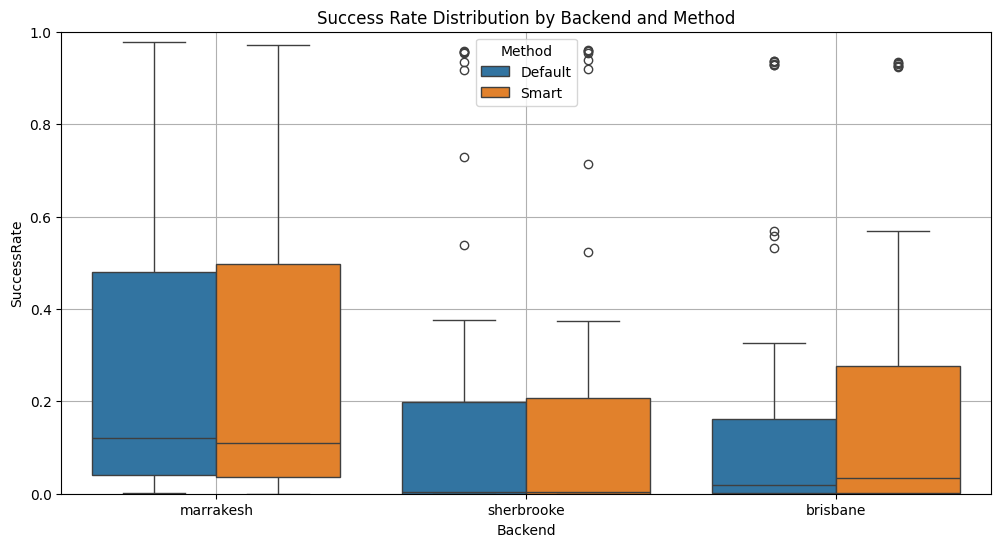

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x="Backend", y="SuccessRate", hue="Method", data=df)
plt.title("Success Rate Distribution by Backend and Method")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Average Performance for each method and backend.

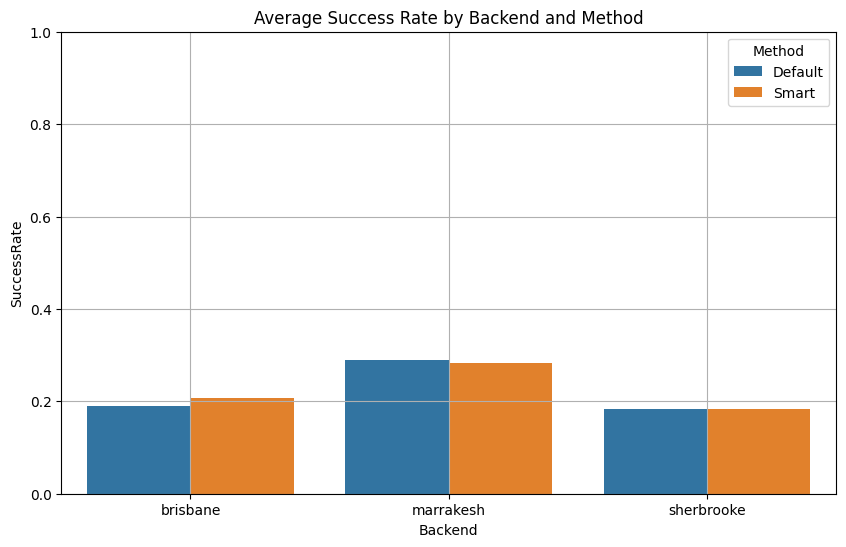

In [ ]:
mean_df = df.groupby(["Backend", "Method"]).mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x="Backend", y="SuccessRate", hue="Method", data=mean_df)
plt.title("Average Success Rate by Backend and Method")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

### Qubit

Now we look at success rate with number of qubits for the different methods.

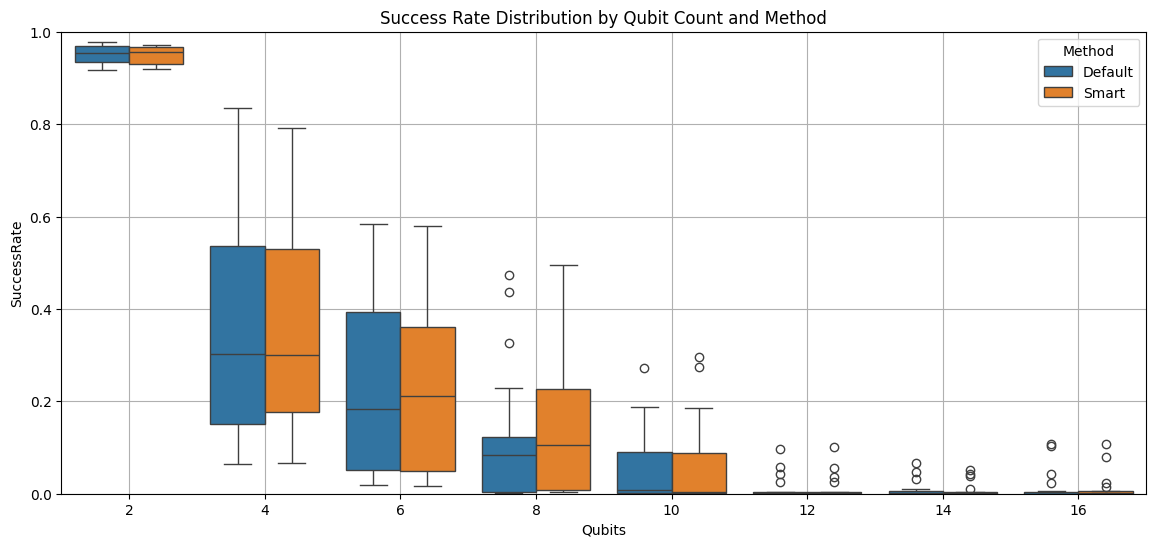

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.boxplot(x="Qubits", y="SuccessRate", hue="Method", data=df)
plt.title("Success Rate Distribution by Qubit Count and Method")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Average by Qubit count for the differnt methods.

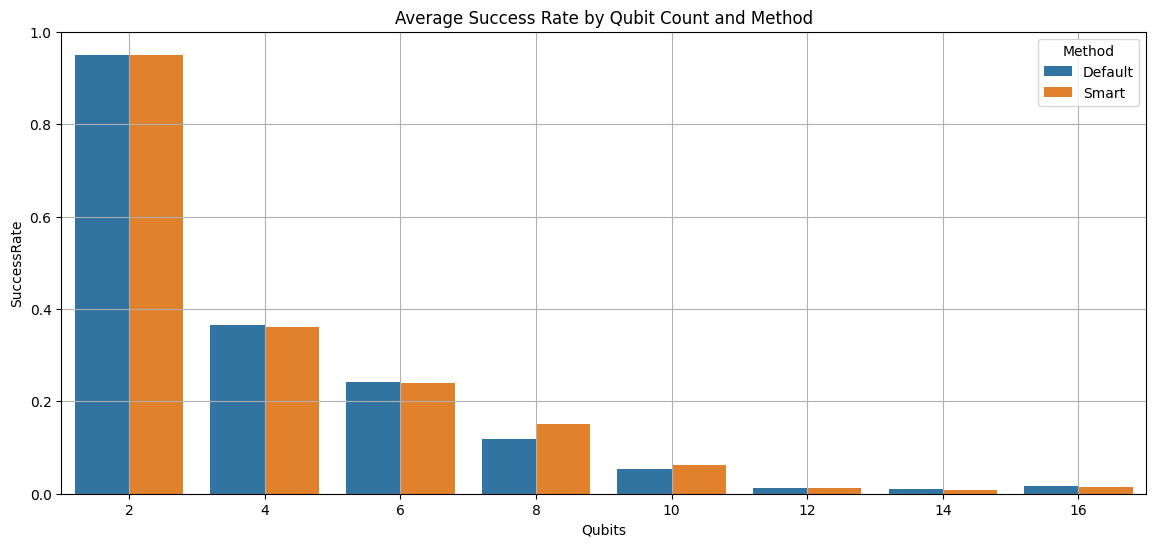

In [ ]:
mean_df_qubits = df.groupby(["Qubits", "Method"])["SuccessRate"].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x="Qubits", y="SuccessRate", hue="Method", data=mean_df_qubits)
plt.title("Average Success Rate by Qubit Count and Method")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

### Circuit depth

Success rate for depth for different methods

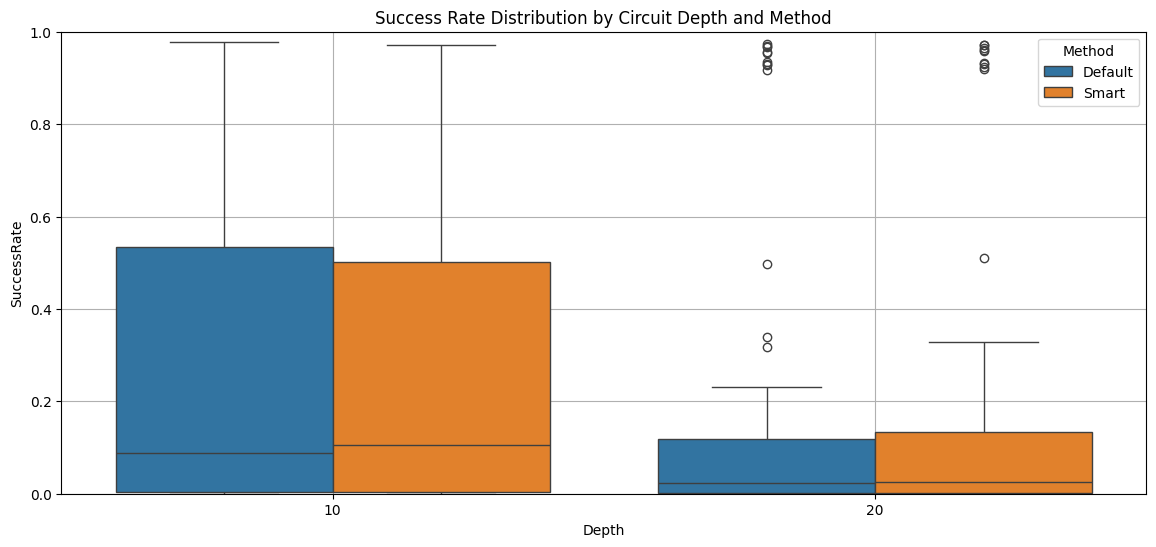

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(x="Depth", y="SuccessRate", hue="Method", data=df)
plt.title("Success Rate Distribution by Circuit Depth and Method")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Average for depth for different methods

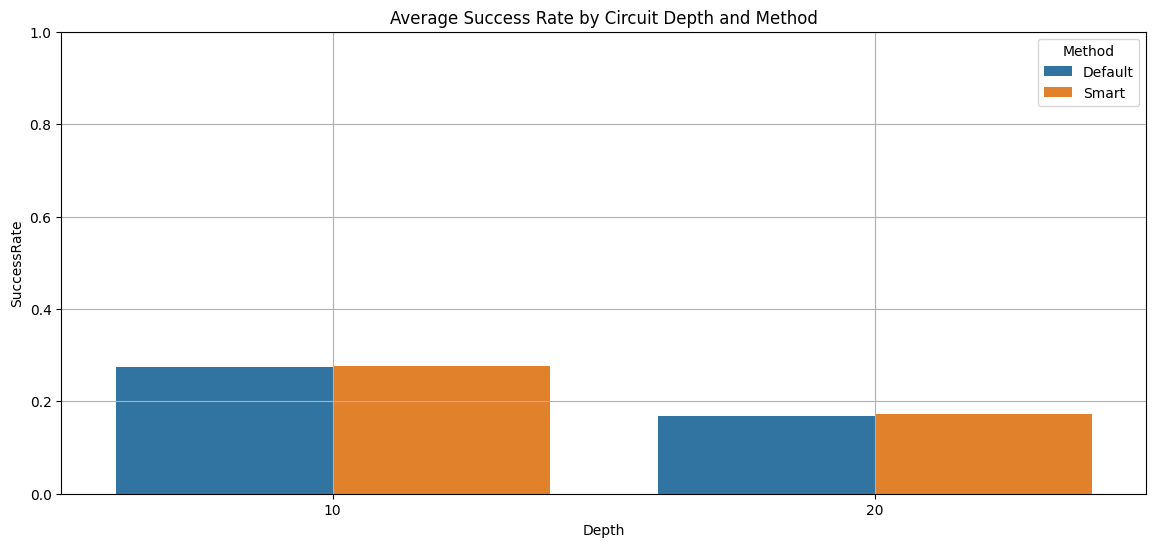

In [ ]:
mean_df_depth = df.groupby(["Depth", "Method"])["SuccessRate"].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x="Depth", y="SuccessRate", hue="Method", data=mean_df_depth)
plt.title("Average Success Rate by Circuit Depth and Method")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


### Realtive Infidelity Reduction


In [ ]:
# Pivot your existing df
pivoted = df.pivot_table(index=["Backend", "Qubits", "Depth"], columns="Method", values="SuccessRate").reset_index()

# Calculate Relative Infidelity Reduction
pivoted["RelInfReduction"] = (1 - pivoted["Smart"]) / (1 - pivoted["Default"])


NameError: name 'df' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Histogram of Relative Infidelity Reduction ---
plt.figure(figsize=(10, 6))
plt.hist(pivoted["RelInfReduction"], bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Relative Infidelity Reduction")
plt.xlabel("Relative Infidelity Reduction (Smart / Default)")
plt.ylabel("Number of Circuits")
plt.axvline(x=1.0, color='red', linestyle='--', label='No Improvement')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Boxplot by Backend ---
plt.figure(figsize=(12, 6))
sns.boxplot(x="Backend", y="RelInfReduction", data=pivoted)
plt.axhline(y=1.0, color='red', linestyle='--')
plt.title("Relative Infidelity Reduction by Backend")
plt.ylabel("Relative Infidelity Reduction")
plt.grid(True)
plt.show()

# --- 3. Boxplot by Qubits ---
plt.figure(figsize=(12, 6))
sns.boxplot(x="Qubits", y="RelInfReduction", data=pivoted)
plt.axhline(y=1.0, color='red', linestyle='--')
plt.title("Relative Infidelity Reduction by Qubit Count")
plt.ylabel("Relative Infidelity Reduction")
plt.grid(True)
plt.show()

# --- 4. Boxplot by Depth ---
plt.figure(figsize=(12, 6))
sns.boxplot(x="Depth", y="RelInfReduction", data=pivoted)
plt.axhline(y=1.0, color='red', linestyle='--')
plt.title("Relative Infidelity Reduction by Circuit Depth")
plt.ylabel("Relative Infidelity Reduction")
plt.grid(True)
plt.show()

NameError: name 'pivoted' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# --- Mean per Backend ---
mean_backend = pivoted.groupby("Backend")["RelInfReduction"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(mean_backend["Backend"], mean_backend["RelInfReduction"], color='lightgreen', edgecolor='black')
plt.axhline(y=1.0, color='red', linestyle='--')
plt.title("Mean Relative Infidelity Reduction by Backend")
plt.ylabel("Mean Relative Infidelity Reduction")
plt.grid(True)
plt.show()

# --- Mean per Qubits ---
mean_qubits = pivoted.groupby("Qubits")["RelInfReduction"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(mean_qubits["Qubits"].astype(str), mean_qubits["RelInfReduction"], color='lightcoral', edgecolor='black')
plt.axhline(y=1.0, color='red', linestyle='--')
plt.title("Mean Relative Infidelity Reduction by Qubit Count")
plt.ylabel("Mean Relative Infidelity Reduction")
plt.grid(True)
plt.show()

print(mean_qubits["RelInfReduction"])

# --- Mean per Depth ---
mean_depth = pivoted.groupby("Depth")["RelInfReduction"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(mean_depth["Depth"].astype(str), mean_depth["RelInfReduction"], color='lightblue', edgecolor='black')
plt.axhline(y=1.0, color='red', linestyle='--')
plt.title("Mean Relative Infidelity Reduction by Circuit Depth")
plt.ylabel("Mean Relative Infidelity Reduction")
plt.grid(True)
plt.show()

NameError: name 'pivoted' is not defined